# Model Development

In [10]:
import sqlite3
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import datetime
import os
from portfolio_management import PortfolioManager
from model import Model
from tqdm import tqdm

In [11]:
conn = sqlite3.connect('db_crypto.db')
query = 'SELECT * FROM crypto_bars'
crypto_bars = pd.read_sql_query(query, conn)
conn.close()
crypto_bars.head()

,id,timestamp,symbol,close,high,low,trade_count,open,volume,vwap,added_on
0,1,2022-01-01 00:00:00,BTC/USD,46651.01,46729.39,46208.24,1958,46212.06,27.991050,46461.287049,2023-11-25 01:35:58
1,2,2022-01-01 01:00:00,BTC/USD,46780.39,46930.01,46560.53,1481,46651.01,26.045432,46758.217158,2023-11-25 01:35:58
2,3,2022-01-01 02:00:00,BTC/USD,46809.99,46926.30,46718.02,890,46773.86,17.050182,46815.889523,2023-11-25 01:35:58
3,4,2022-01-01 03:00:00,BTC/USD,46795.43,46888.19,46750.00,748,46817.49,14.247804,46823.051862,2023-11-25 01:35:58
4,5,2022-01-01 04:00:00,BTC/USD,46704.12,46875.38,46626.68,1072,46797.98,28.309908,46729.639265,2023-11-25 01:35:58


In [12]:
crypto_prices = crypto_bars[['timestamp', 'symbol', 'close']].copy()
crypto_prices = crypto_prices.pivot(index='timestamp', columns='symbol', values='close')
crypto_prices.index.name = 'date'
crypto_prices.columns.name = None
crypto_prices = crypto_prices.loc[lambda df: ~df.index.isna(), :]
crypto_prices.index = crypto_prices.index.map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
crypto_prices = crypto_prices.fillna(method='ffill')
crypto_prices.head()

,BTC/USD,ETH/USD,UNI/USD
date,,,
2022-01-01 00:00:00,46651.01,3722.24,17.1814
2022-01-01 01:00:00,46780.39,3725.26,17.3031
2022-01-01 02:00:00,46809.99,3728.30,17.2791
2022-01-01 03:00:00,46795.43,3724.21,17.1614
2022-01-01 04:00:00,46704.12,3707.42,17.2214


<Axes: title={'center': 'Cumulative Returns'}, xlabel='date'>

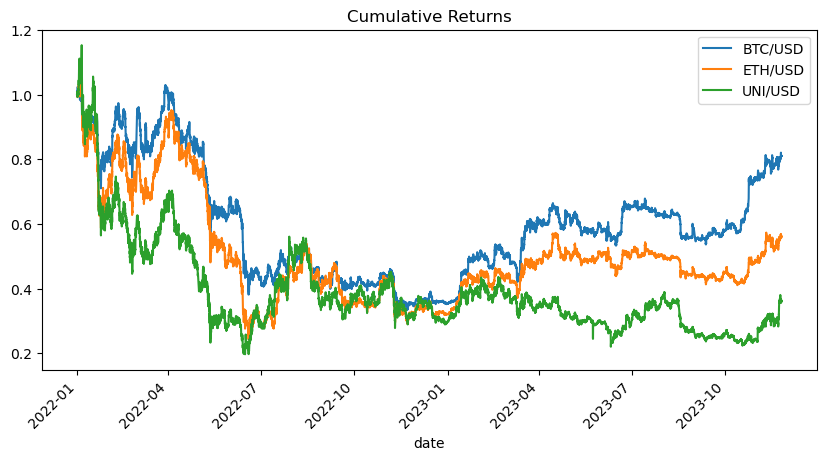

In [13]:
(
    crypto_prices
    .pct_change()
    .dropna()
    .apply(lambda x: x + 1)
    .cumprod()
    .plot(figsize=(10, 5), title='Cumulative Returns', rot=45)
)

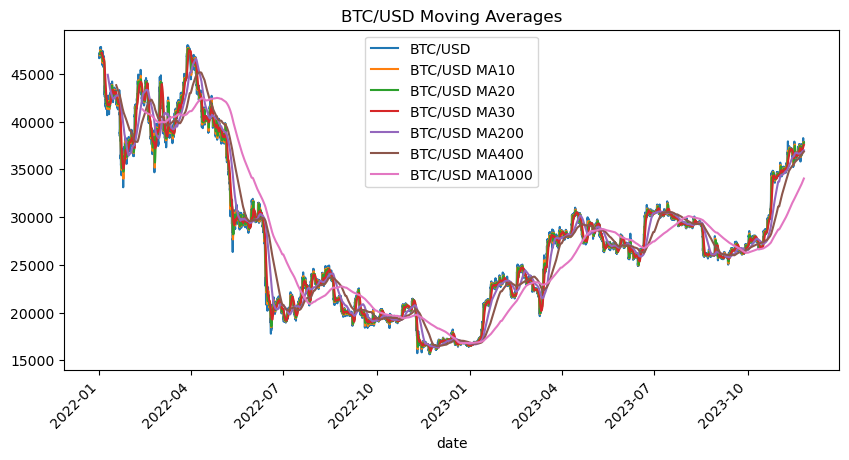

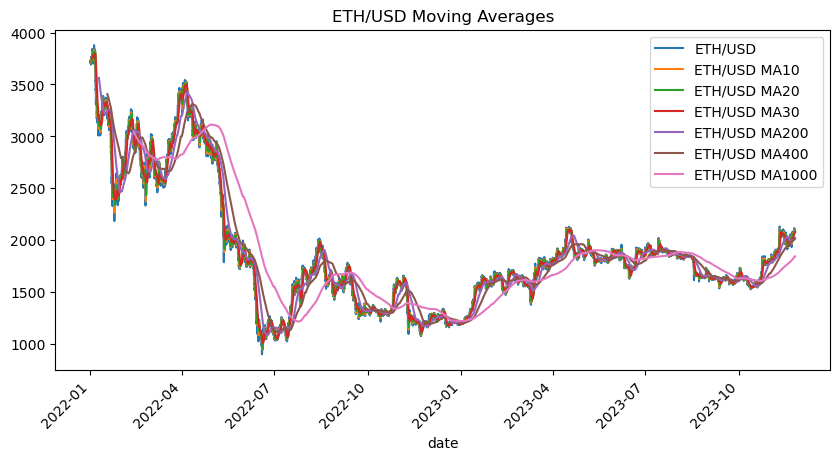

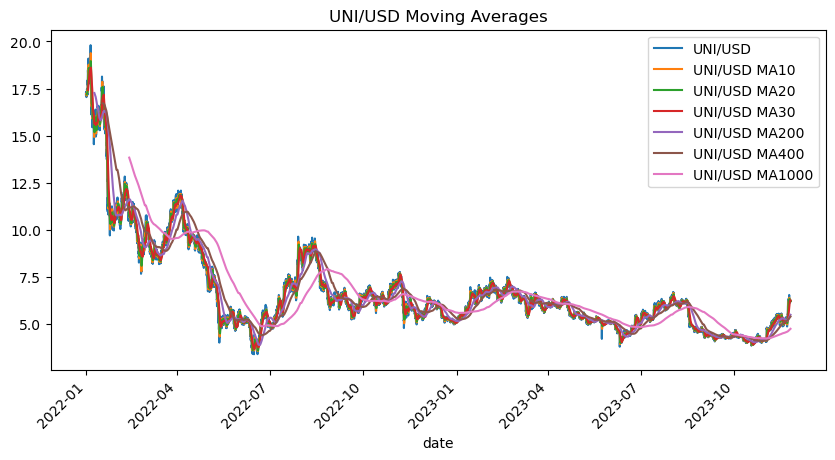

In [14]:
crypto_symbols = crypto_prices.columns.tolist()
crypto_price_features = (
    crypto_prices
    .assign(
        **{f'{symbol} MA10': crypto_prices[symbol].rolling(10).mean() for symbol in crypto_symbols},
        **{f'{symbol} MA20': crypto_prices[symbol].rolling(20).mean() for symbol in crypto_symbols},
        **{f'{symbol} MA30': crypto_prices[symbol].rolling(50).mean() for symbol in crypto_symbols},
        **{f'{symbol} MA200': crypto_prices[symbol].rolling(200).mean() for symbol in crypto_symbols},
        **{f'{symbol} MA400': crypto_prices[symbol].rolling(400).mean() for symbol in crypto_symbols},
        **{f'{symbol} MA1000': crypto_prices[symbol].rolling(1000).mean() for symbol in crypto_symbols},
    )
)
for symbol in crypto_symbols:
    (
        crypto_price_features
        .filter(regex=f'{symbol}')
        .plot(figsize=(10, 5), title=f'{symbol} Moving Averages', rot=45)
    )

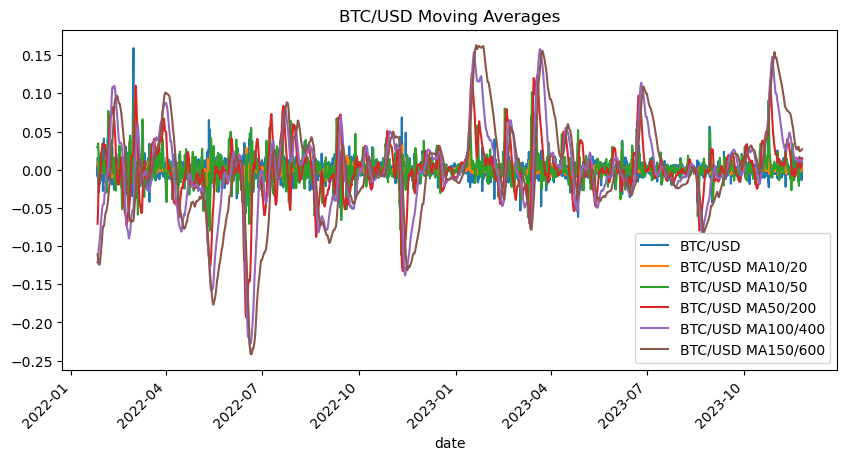

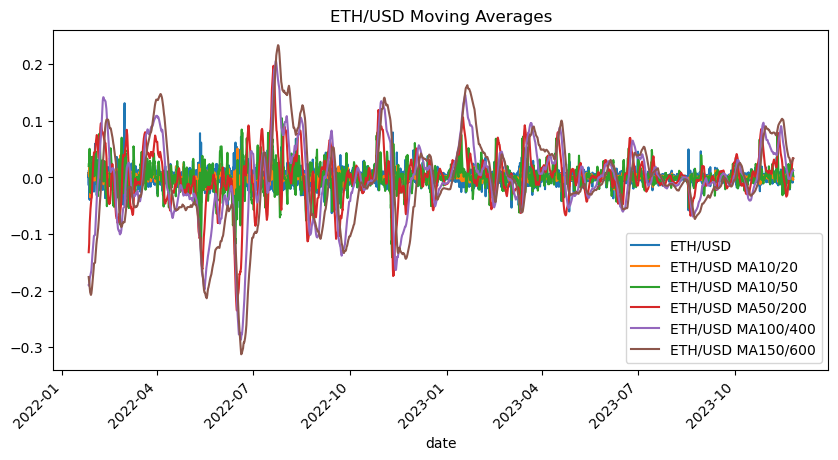

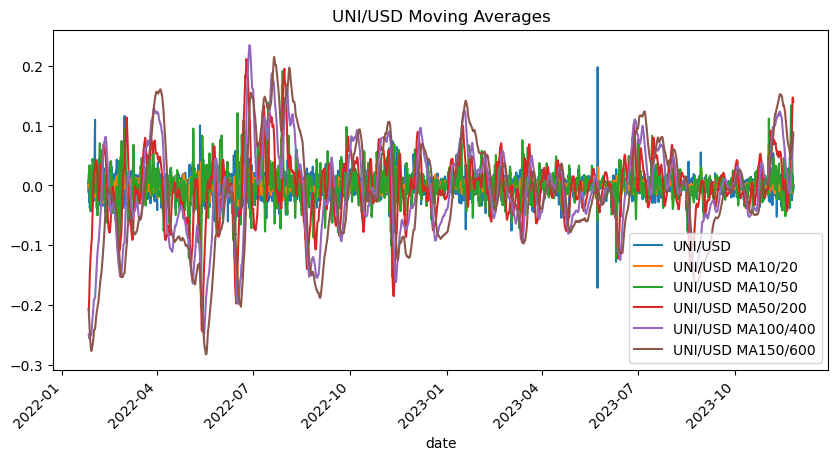

In [15]:
crypto_symbols = crypto_prices.columns.tolist()
crypto_features = (
    crypto_prices
    .assign(
        **{f'{symbol} MA10/20': crypto_prices[symbol].rolling(10).mean() / crypto_prices[symbol].rolling(20).mean() - 1 for symbol in crypto_symbols},
        **{f'{symbol} MA10/50': crypto_prices[symbol].rolling(10).mean() / crypto_prices[symbol].rolling(50).mean() - 1 for symbol in crypto_symbols},
        **{f'{symbol} MA50/200': crypto_prices[symbol].rolling(50).mean() / crypto_prices[symbol].rolling(200).mean() - 1 for symbol in crypto_symbols},
        **{f'{symbol} MA100/400': crypto_prices[symbol].rolling(100).mean() / crypto_prices[symbol].rolling(400).mean() - 1 for symbol in crypto_symbols},
        **{f'{symbol} MA150/600': crypto_prices[symbol].rolling(150).mean() / crypto_prices[symbol].rolling(600).mean() - 1 for symbol in crypto_symbols},
    )
    .assign(**{symbol: crypto_prices[symbol].pct_change() for symbol in crypto_symbols})
)
crypto_features.dropna(inplace=True)
for symbol in crypto_symbols:
    (
        crypto_features
        .filter(regex=f'{symbol}')
        .plot(figsize=(10, 5), title=f'{symbol} Moving Averages', rot=45)
    )

In [16]:
crypto_features.asfreq('H')
model = VAR(crypto_features)
fitted_model = model.fit(maxlags=15, ic='aic')
prediction = fitted_model.forecast(crypto_features.values[-fitted_model.k_ar:], steps=1)
print('Predictions of returns and moving averages for the next hour:')
prediction[0]

/Users/fernandorochacorreaurbano/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Predictions of returns and moving averages for the next hour:


array([-0.00054215, -0.00050455,  0.00048265, -0.0006415 , -0.00284025,
        0.00322722,  0.00646841,  0.0031141 , -0.00491523,  0.01500198,
        0.03313094,  0.13868254,  0.01010121,  0.01234858,  0.08475096,
        0.02696849,  0.03409181,  0.08961226])

In [17]:
datetimes_threshold = pd.date_range(datetime.datetime(2023, 1, 5), datetime.datetime.now(), freq='H')

if 'backtest_weights.csv' in os.listdir():
    backtest_weights = pd.read_csv('backtest_weights.csv', index_col=0, parse_dates=True)
    max_calculated_threshold = backtest_weights.index.max()
    datetimes_threshold = [d for d in datetimes_threshold if d >= max_calculated_threshold]
else:
    backtest_weights = pd.DataFrame(columns=crypto_symbols)

model = Model()
portfolio_manager = PortfolioManager()
extra_calculations = 0
for datetime_threshold in tqdm(datetimes_threshold, desc='Processing'):
    model.get_data(max_datetime=datetime_threshold)
    model.transform_data()
    if model.prediction_datetime in backtest_weights.index:
        continue
    model.fit()
    predicted_returns = model.predict()
    cov_matrix = model.calc_cov_matrix()
    portfolio_manager.get_predictions(predicted_returns, cov_matrix)
    target_weights = portfolio_manager.allocate() 
    backtest_weights = pd.concat([
        backtest_weights,
        pd.DataFrame(target_weights, index=[model.prediction_datetime])
    ])
    extra_calculations += 1
    if extra_calculations % 10 == 0 or datetimes_threshold[-1] == datetime_threshold:
        backtest_weights.to_csv('backtest_weights.csv')

Processing: 100%|██████████| 2432/2432 [1:47:01<00:00,  2.64s/it]  


In [29]:
backtest_weighted_returns = (
    backtest_weights
    .rename(columns=lambda c: c + " Weight")
    .join(crypto_features[crypto_symbols])
    .assign(
        **{f'{symbol} Weighted Return': lambda df, s=symbol: df[s] * df[f'{s} Weight'] for symbol in crypto_symbols},
    )
)
backtest_weighted_returns.head(5)

,BTC/USD Weight,ETH/USD Weight,UNI/USD Weight,BTC/USD,ETH/USD,UNI/USD,BTC/USD Weighted Return,ETH/USD Weighted Return,UNI/USD Weighted Return
2023-01-05 01:00:00,0.296022,0.305153,0.398826,0.000346,0.000327,0.001977,0.000102,0.000100,0.000788
2023-01-05 02:00:00,0.429149,0.275691,0.295159,0.000312,-0.000255,-0.004073,0.000134,-0.000070,-0.001202
2023-01-05 03:00:00,0.305629,0.377419,0.316952,-0.000579,-0.000965,-0.001109,-0.000177,-0.000364,-0.000351
2023-01-05 04:00:00,0.305789,0.382597,0.311614,0.000381,0.000367,0.005968,0.000117,0.000141,0.001860
2023-01-05 05:00:00,0.631115,0.094600,0.274285,0.000613,0.000239,0.001791,0.000387,0.000023,0.000491


In [48]:
backtest_portfolio_returns = (
    backtest_weighted_returns
    .filter(regex='Weighted Return')
    .sum(axis=1)
    .to_frame('Portfolio Return')
    .join(crypto_features[['BTC/USD', 'ETH/USD', 'UNI/USD']], how='inner')
)
backtest_portfolio_returns.head(5)

,Portfolio Return,BTC/USD,ETH/USD,UNI/USD
2023-01-05 01:00:00,0.000991,0.000346,0.000327,0.001977
2023-01-05 02:00:00,-0.001139,0.000312,-0.000255,-0.004073
2023-01-05 03:00:00,-0.000893,-0.000579,-0.000965,-0.001109
2023-01-05 04:00:00,0.002117,0.000381,0.000367,0.005968
2023-01-05 05:00:00,0.000900,0.000613,0.000239,0.001791


<Axes: title={'center': 'Backtest Portfolio Returns'}>

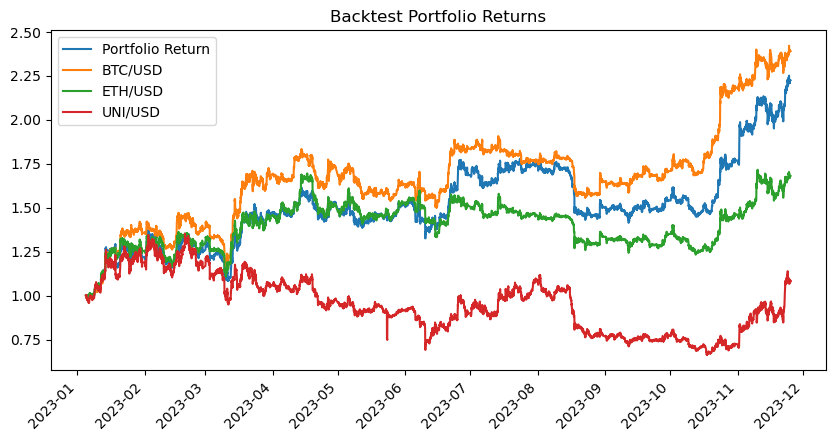

In [49]:
(
    backtest_portfolio_returns
    .apply(lambda x: x + 1)
    .cumprod()
    .plot(figsize=(10, 5), title='Backtest Portfolio Returns', rot=45)
)

<Axes: title={'center': 'Backtest Portfolio Returns'}>

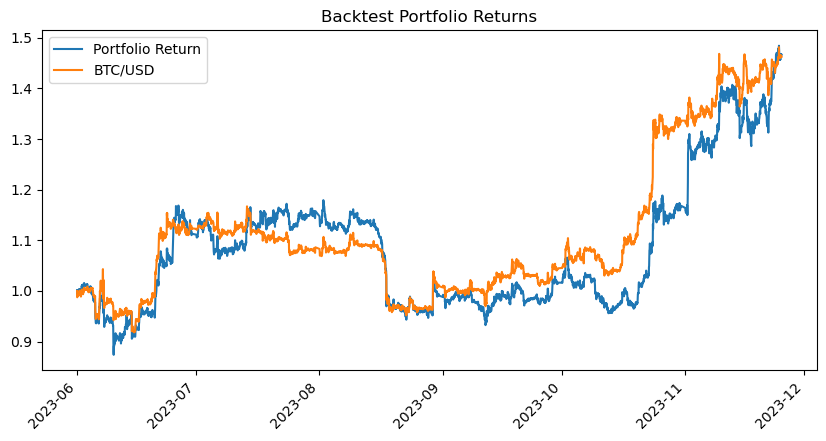

In [39]:
(
    backtest_portfolio_returns
    .loc[lambda df: df.index >= '2023-06-01']
    .apply(lambda x: x + 1)
    .cumprod()
    .plot(figsize=(10, 5), title='Backtest Portfolio Returns', rot=45)
)

In [50]:
(
    backtest_portfolio_returns
    .loc[lambda df: df.index >= '2023-06-01']
    .agg([
        'mean',
        'std',
        lambda x: x.mean() / x.std(),
        'min',
        'max',
        'skew',
        'kurtosis'
    ])
    .set_axis(['Mean', 'Std', 'Mean/Vol', 'Min', 'Max', 'Skew', 'Kurtosis'], axis=0)
)

,Portfolio Return,BTC/USD,ETH/USD,UNI/USD
Mean,0.000104,0.000100,0.000032,0.000069
Std,0.004735,0.004043,0.004340,0.007542
Mean/Vol,0.021919,0.024760,0.007442,0.009084
Min,-0.058525,-0.042443,-0.057937,-0.127802
Max,0.054737,0.056273,0.049589,0.055185
Skew,0.018719,0.875961,-0.098094,-1.336817
Kurtosis,20.835120,30.221639,28.955977,28.732899


In [53]:
(
    backtest_portfolio_returns
    .assign(**{f"Portfolio - {symbol}": lambda df, s=symbol: df['Portfolio Return'] - df[s] for symbol in crypto_symbols})
    .filter(regex='Portfolio -')
    .agg([
        'mean',
        'std',
        lambda x: x.mean() / x.std(),
        'min',
        'max',
        'skew',
        'kurtosis'
    ])
    .set_axis(['Mean', 'Std', 'Mean/Vol', 'Min', 'Max', 'Skew', 'Kurtosis'], axis=0)
)

,Portfolio - BTC/USD,Portfolio - ETH/USD,Portfolio - UNI/USD
Mean,-0.000007,0.000039,0.000077
Std,0.002757,0.002483,0.004939
Mean/Vol,-0.002437,0.015583,0.015631
Min,-0.055720,-0.046636,-0.166254
Max,0.045366,0.041731,0.141928
Skew,0.036425,-0.626036,-1.957791
Kurtosis,56.702591,62.151323,291.956289


In [58]:
(
    backtest_portfolio_returns
    .assign(**{f"Portfolio - {symbol}": lambda df, s=symbol: df['Portfolio Return'] - df[s] for symbol in crypto_symbols})
    .filter(regex='Portfolio -')
    .loc[lambda df: df.index >= '2023-06-01']
    .agg([
        'mean',
        'std',
        lambda x: x.mean() / x.std(),
        'min',
        'max',
        'skew',
        'kurtosis'
    ])
    .set_axis(['Mean', 'Std', 'Mean/Vol', 'Min', 'Max', 'Skew', 'Kurtosis'], axis=0)
)

,Portfolio - BTC/USD,Portfolio - ETH/USD,Portfolio - UNI/USD
Mean,0.000004,0.000071,0.000035
Std,0.002688,0.002439,0.004529
Mean/Vol,0.001375,0.029317,0.007790
Min,-0.018446,-0.027509,-0.051100
Max,0.045366,0.041731,0.090381
Skew,2.434037,1.801426,1.518455
Kurtosis,37.473948,42.678689,50.706519


<Axes: title={'center': 'Backtest Portfolio Returns'}>

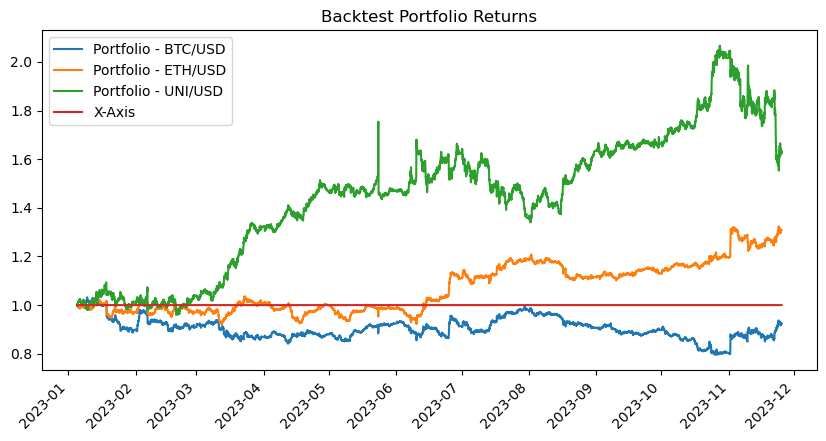

In [60]:
(
    backtest_portfolio_returns
    .assign(**{f"Portfolio - {symbol}": lambda df, s=symbol: df['Portfolio Return'] - df[s] for symbol in crypto_symbols})
    .filter(regex='Portfolio -')
    .apply(lambda x: x + 1)
    .cumprod()
    .assign(**{"X-Axis": 1})
    .plot(figsize=(10, 5), title='Backtest Portfolio Returns', rot=45)
)

<Axes: title={'center': 'Backtest Portfolio Returns'}>

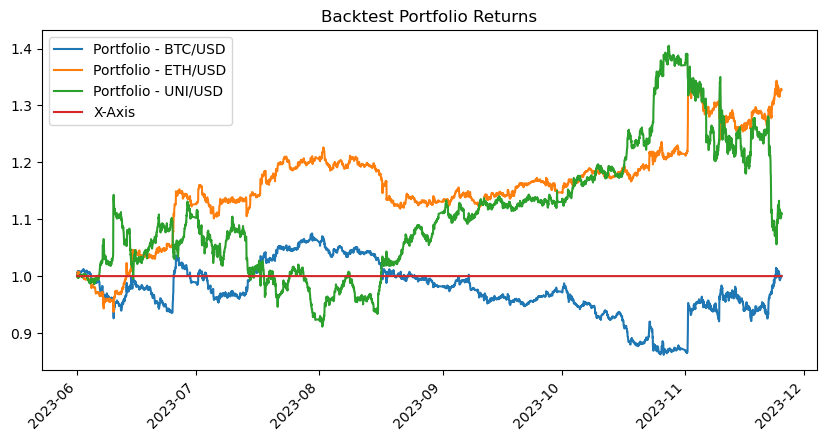

In [61]:
(
    backtest_portfolio_returns
    .assign(**{f"Portfolio - {symbol}": lambda df, s=symbol: df['Portfolio Return'] - df[s] for symbol in crypto_symbols})
    .filter(regex='Portfolio -')
    .loc[lambda df: df.index >= '2023-06-01']
    .apply(lambda x: x + 1)
    .cumprod()
    .assign(**{"X-Axis": 1})
    .plot(figsize=(10, 5), title='Backtest Portfolio Returns', rot=45)
)